# Решающие деревья. Практика

В этом задании будем решать задачу классификации клиентов телекома: для каждого клиента необходимо определить, перестанет он пользоваться услугами оператора (оттоковый клиент) в ближайшее время или нет.

В ноутбуке будем использовать несколько моделей, в том числе SVM, поэтому установим библиотеку для быстрого обучения SVM.

## Импорт библиотек и загрузка данных

In [1]:
# убедимся, что версия python < 3.10
!python --version

Python 3.7.7


In [ ]:
%%capture
!python -m pip install --upgrade pip
!pip install --upgrade scikit-learn-intelex

In [2]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
import sys
import os
import site
import pandas as pd
import numpy as np

sys.path.append(os.path.join(os.path.dirname(site.getsitepackages()[0]), "site-packages"))

In [3]:
# зафиксируем константы
RANDOM_STATE = 42

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/telecom_churn.csv")
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## Практика

In [6]:
np.random.seed(RANDOM_STATE)

Сделайте первичную обработку данных:

1) Выбросите колонку State

2) Колонки International plan и Voice mail plan закодируйте следующим образом: "Yes" замените на 1, а "No" на 0.

3) Переведите целевую переменную (Churn) в числа: True в 1, а False в 0.

In [6]:
df = df.drop('State', axis=1)
cols = ['Voice mail plan', 'International plan']
df[cols] = df[cols].apply(lambda x : x.apply(lambda  y: 1 if y=='Yes' else 0))

### Вопрос

Чему равна сумма значений в закодированном столбце International plan?

In [7]:
# df['Churn'] = df['Churn'].map({'True' : 1, 'False' : 0})
df['Churn'] = df['Churn'].apply(lambda  x : 1 if x==True else 0 ) #323

Выведите на экран первые строки измененной таблицы, чтобы проверить, что все преобразования сработали.

In [8]:
df['Churn'].sum()

483

Создайте матрицу объект-признак X и вектор с целевой переменной (Churn) y.

In [9]:
X = df.drop('Churn', axis=1)
y = df['Churn']

### Вопрос

Проверьте баланс классов. Является ли выборка сбалансированной?

In [10]:
y.value_counts()

0    2850
1     483
Name: Churn, dtype: int64

По кросс-валидации с тремя фолдами и метрикой ROC-AUC (scoring='roc_auc') обучите:

1) Логистическую регрессию

2) Метод опорных векторов (с kernel='linear')

Выведите на экран среднее качество моделей на кросс-валидации.

При объявлении SVC не забудьте указать в гиперпараметрах probability = True (так как метод изначально не предсказывает вероятности классов, а они нам нужны для вычисления ROC-AUC).

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
model_lr = LogisticRegression()
model_svc = SVC(probability=True, kernel='linear')
# scores_lr = cross_val_score(X=X, y=y, estimator=model_lr, scoring='roc_auc', cv=3).mean()
# scores_svc = cross_val_score(X=X, y=y, estimator=model_svc, scoring='roc_auc', cv=3).mean()

Теперь обучите решающее дерево с параметрами по умолчанию по кросс-валидации с тремя фолдами и той же метрикой.

ВАЖНО! У решающего дерева для воспроизводимости результатов фиксируйте random_state = RANDOM_STATE

In [13]:
from sklearn.tree import DecisionTreeClassifier
model_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
score_tree = cross_val_score(X=X, y=y, estimator=model_tree, scoring='roc_auc', cv=3).mean()

print(scores_lr, scores_svc, score_tree)

NameError: name 'scores_lr' is not defined

### Вопрос

Какой из трех алгоритмов показал наилучшее качество на кросс-валидации?

Ваша цель - максимально улучшить модели. Для этого:

1) у линейных моделей подберите гиперпараметр С (переберите 20 значений C в диапазоне от 0.1 до 10 с равным шагом).

2) у решающего дерева подберите max_depth (переберите глубину от 1 до 10 с шагом 1) и criterion - "gini" или "entropy".

Для подбора параметров используйте GridSearchCV с тремя фолдами и метрикой roc-auc или обычные циклы.

Подбор параметров осуществляется только по тренировочным данным!

При подборе гиперпараметров по кросс-валидации для дальнейшей корректной оценки качества модели нужна отдельная выборка. Давайте сразу действовать правильно:

1) сначала разбиваем (как и раньше) данные на тренировочную и тестовую части
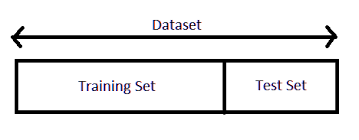

2) затем по тренировочной части при помощи GridSearchCV подбираем оптимальные значения гиперпараметров

3) наконец, делаем предсказание модели с оптимальными гиперпараметрами на тестовых данных и уже по ним оцениваем итоговую метрику.

Сложно, зато правильно!

Первую модель обучим для примера. Дальше вы сами.

In [14]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

In [43]:
from sklearn.model_selection import GridSearchCV

params = {'C' : np.linspace(0.1, 10.01, 20)}

gs = GridSearchCV(LogisticRegression(), params, cv=3, scoring='roc_auc')

gs.fit(Xtrain, ytrain)

gs.best_score_, gs.best_estimator_

/home/fltww/anaconda3/envs/ML/lib/python3.7/site-packages/daal4py/sklearn/linear_model/logistic_path.py:578: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/fltww/anaconda3/envs/ML/lib/python3.7/site-packages/daal4py/sklearn/linear_model/logistic_path.py:578: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-l

/home/fltww/anaconda3/envs/ML/lib/python3.7/site-packages/daal4py/sklearn/linear_model/logistic_path.py:578: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/fltww/anaconda3/envs/ML/lib/python3.7/site-packages/daal4py/sklearn/linear_model/logistic_path.py:578: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-l

/home/fltww/anaconda3/envs/ML/lib/python3.7/site-packages/daal4py/sklearn/linear_model/logistic_path.py:578: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/fltww/anaconda3/envs/ML/lib/python3.7/site-packages/daal4py/sklearn/linear_model/logistic_path.py:578: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-l

/home/fltww/anaconda3/envs/ML/lib/python3.7/site-packages/daal4py/sklearn/linear_model/logistic_path.py:578: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/fltww/anaconda3/envs/ML/lib/python3.7/site-packages/daal4py/sklearn/linear_model/logistic_path.py:578: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-l

(0.7115534776451381, LogisticRegression(C=8.966842105263158))

In [55]:
from sklearn.metrics import roc_auc_score

lr = gs.best_estimator_

pred_lr = lr.predict_proba(Xtest)[:,1]
roc_auc_lr = roc_auc_score(ytest, pred_lr)
print(roc_auc_score(ytest, pred_lr))

0.7844244437009897


In [72]:
param_grid = {
    'C' : np.linspace(0.1, 10.01, 20),
}
grid_model_svc = GridSearchCV(estimator=model_svc, param_grid=param_grid, cv=3, scoring='roc_auc')
grid_model_svc.fit(Xtrain, ytrain)
predict_svc = grid_model_svc.best_estimator_.predict_proba(Xtest)[:,1]

/home/fltww/anaconda3/envs/ML/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/home/fltww/anaconda3/envs/ML/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/fltww/anaconda3/envs/ML/lib/python3.7/site-packages/sklearnex/svm/svc.py", line 93, in fit
    }, X, y, sample_weight)
  File "/home/fltww/anaconda3/envs/ML/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 163, in dispatch
    return branches[backend]

ValueError: 'Linear' is not in list

In [18]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth' : range(1,11),
    'criterion' : ['gini', 'entropy']
}
grid_model_tree = GridSearchCV(estimator=DecisionTreeClassifier(random_state=RANDOM_STATE), param_grid=param_grid, cv=3, scoring='roc_auc')
grid_model_tree.fit(Xtrain, ytrain)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 11)},
             scoring='roc_auc')

### Вопрос

Чему равно качество решающего дерева с подобранными гиперпараметрами, посчитанное на тестовой выборке?

Ответ округлите до сотых.

In [19]:
predict_tree = grid_model_tree.best_estimator_.predict_proba(Xtest)[:,1]
roc_auc_tree = roc_auc_score(ytest, predict_tree)
roc_auc_tree

0.8555540142471298

Какая модель справилась с решением задачи лучше всего по метрике roc_auc?

Нарисуйте roc-кривую для наилучшей модели.

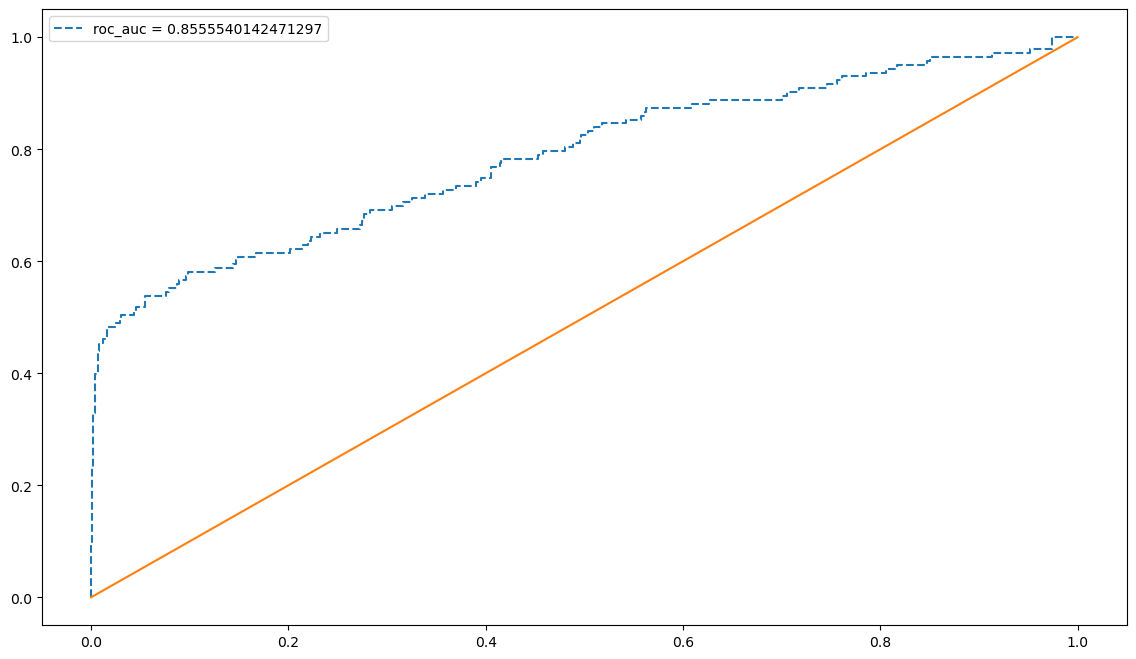

In [67]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
plt.figure(figsize=(14,8))
fpr, tpr, thr = roc_curve(ytest, predict_svc)
plt.plot(fpr, tpr, linestyle='--', label=f'roc_auc = {roc_auc_tree}')
plt.plot([0,1], [0,1])
plt.legend()

Сравните между собой две лучшие модели.

### Вопрос

Насколько сильно отличается качество предсказания на тестовых данных?
(вычислите разность значений roc-auc)

In [70]:
print(roc_auc_tree-roc_auc_svc)

0.06895904562182276


Постройте гистограммы важности признаков (для линейных моделей берите модуль значений весов) для каждой из этих моделей. Сравните между собой списки из трех самых важных признаков. Совпадают ли они?

### Вопрос

Какой признак наиболее важен для решающего дерева?

In [30]:
importance = grid_model_tree.best_estimator_.feature_importances_

In [40]:
data = pd.DataFrame({'feature' : X.columns, 'importance' : importance})
data.sort_values('importance')[::-1]

,feature,importance
7,Total day charge,0.255882
17,Customer service calls,0.148730
15,Total intl calls,0.119125
2,International plan,0.107456
16,Total intl charge,0.077777
8,Total eve minutes,0.075397
4,Number vmail messages,0.072051
10,Total eve charge,0.069741
5,Total day minutes,0.023417
13,Total night charge,0.017825


12
13
Вася


Сделайте выводы (для себя)

1) Являются ли данные сбалансированными? Что это означает?

2) Какая модель после подбора гиперпараметров лучше всего решает задачу с точки зрения метрики roc-auc?

3) Одинаковые ли признаки важны для работы двух наилучших моделей? Как вы думаете, почему так?